In [1]:
import smart_open
import gensim
import pandas as pd
import codecs

In [2]:
sentences = gensim.models.word2vec.PathLineSentences("C:/Users/espen/Documents/SDS/thesis/data/processed/sentences/year_txt")
avg_sentence_length = []
avg_word_length = []
for year in sentences.input_files:
    sentence_length, word_length = [], []
    words = []
    sentences = []
    with codecs.open(year,encoding="utf-8") as txt:
        for sentence in txt.readlines():
            tokenized_sentence = sentence.split(" ")
            sentences.append(tokenized_sentence)
            words.extend(tokenized_sentence)
        length_of_words = [len(word) for word in words]
        length_of_sentences = [len(sentence) for sentence in sentences]
    avg_sentence_length.append(sum(length_of_sentences)/len(length_of_sentences))
    avg_word_length.append(sum(length_of_words)/len(length_of_words))


<AxesSubplot:label='35792200-1c12-4491-954a-746aa3864617'>

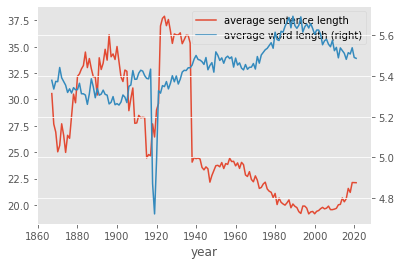

In [3]:
import matplotlib.pyplot as plt
df = pd.DataFrame(zip(range(1867,2022),avg_sentence_length, avg_word_length), columns=["year","average sentence length","average word length"])
df.set_index("year",inplace=True)

plt.style.use('ggplot')
plt.grid(False)
ax = df["average sentence length"].plot(legend=True,grid=False)
plt.grid(False)
df["average word length"].plot(legend=True,secondary_y=True,grid=False)



In [4]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots
# Create figure with secondary y-axis
fig = make_subplots(specs=[[{"secondary_y": True}]])

# Add traces
fig.add_trace(
    go.Scatter(x=df.index, 
               y=df["average sentence length"],
               name="Avg. sentence length (words, left axis)",
               hovertemplate="%{y:.1f}%{_xother}"
    ), secondary_y=False,

)

fig.add_trace(
    go.Scatter(x=df.index, 
               y=df["average word length"],
               name="Avg. word length (characters, right axis)",
               hovertemplate="%{y:.1f}%{_xother}"
    ), secondary_y=True,
)

# Add figure title
fig.update_layout(template="ggplot2",
                legend=dict(
                    yanchor="bottom",
                    y=0.01,
                    xanchor="left",
                    x=0.01
                ),margin=dict(
                        l=0,
                        r=0,
                        b=0,
                        t=0
                ),
                font_family="Serif",
                hovermode="x unified"
                )

# Set x-axis title
fig.update_xaxes(title_text="years")

# Set y-axes titles
fig.update_yaxes(title_text="Avg. word count (sentences)", secondary_y=False, showgrid=False)
fig.update_yaxes(title_text="Avg. character count (words)", secondary_y=True, showgrid=False)
fig.write_html("../../data/plots/average_length_of_sentences_and_words.html")
fig.write_image("../../data/plots/average_length_of_sentences_and_words.pdf")
fig
fig.show()


In [5]:
df_ufr = pd.read_parquet(r"C:\Users\espen\Documents\SDS\thesis\data\processed\pyarrow\UfR_text_keep_linebreaks.parquet")

In [6]:
df_ufr.rename(columns={"verdict_text_x":"verdict_text"}, inplace=True)

In [7]:
from tqdm.auto import tqdm
tqdm.pandas()

In [8]:
import nltk
def tokenize_sentences(verdict_text):
    paragraphs = verdict_text.split("\n")
    sentences = []
    for paragraph in paragraphs:
        sentences.extend(nltk.sent_tokenize(paragraph, language="danish"))
    tokens_in_sentences = [list(gensim.utils.tokenize(sentence)) for sentence in sentences]
    return tokens_in_sentences



In [9]:
df_ufr["sentences"] = df_ufr["verdict_text"].progress_apply(tokenize_sentences)

100%|██████████| 63915/63915 [08:47<00:00, 121.17it/s]


In [10]:
df_ufr["sentences_count"] = df_ufr["sentences"].map(len)
df_ufr["sentences_length"] = df_ufr["sentences"].map(lambda x: [len(y) for y in x])
df_ufr["sentences_length_sum"] = df_ufr["sentences_length"].map(sum)

In [11]:
def clean_category(df):
    year = int(df["year"])
    cat = df["document_category"]
    always_included = ["Højesteret", "Sø- og Handelsretten"]
    high_courts = ["Vestre Landsret", "Østre Landsret"]
    if year < 1920: 
        included_in_plot = always_included 
    else: 
        included_in_plot = always_included + high_courts
    if cat in included_in_plot:
        return cat
    else: 
        return "Other type of court"


df_cat_year = df_ufr.groupby(["year","document_category"]).count()["id_verdict"]/df_ufr.groupby(["year"]).count()["id_verdict"]
df_ufr["document_category_cleaned"] = df_ufr.apply(lambda x: clean_category(x), axis=1)
# df_ufr["document_category_cleaned"] = df_ufr["document_category"].apply(lambda x: x if x in included_in_plot else "Other type of court")


In [12]:
df_gb = df_ufr.groupby(["year","document_category_cleaned"]).sum()
df_gb_count = df_ufr.groupby(["year","document_category_cleaned"])["id_verdict"].count().rename("Count")

In [13]:
df_gb["Average sentence length"] = df_gb["sentences_length_sum"]/df_gb["sentences_count"]
df_gb_total = df_gb.groupby("year").sum()
df_gb_total_count = df_ufr.groupby(["year"])["id_verdict"].count().rename("Count")
df_gb_total = pd.merge(df_gb_total,df_gb_total_count, left_index=True, right_index=True)
df_gb_total["Average sentence length"] = df_gb_total["sentences_length_sum"]/df_gb_total["sentences_count"]
df_gb.reset_index(inplace=True)
df_gb_total.reset_index(inplace=True)
df_gb_total["document_category_cleaned"] = "Overall average"


In [14]:
df_gb = pd.merge(left=df_gb,right=df_gb_count, left_on=("year","document_category_cleaned"),right_index=True)
df_gb = df_gb.append(df_gb_total)


In [15]:
import plotly.express as px
import plotly
df_gb = df_gb.rename(columns=dict(zip(["document_category_cleaned","year","Average sentence length","sentences_count","Count"],["Court","Year", "Average sentence length", "Sentences count", "Document count"])))
df_gb_plot = df_gb.loc[df_gb["Court"]!="Other type of court"]

plt = px.line(df_gb_plot, x="Year", y = "Average sentence length", color="Court", 
                hover_name="Court",
                hover_data={"Year":":.0f",
                            "Court":False, 
                            "Average sentence length":":.1f", 
                            "Sentences count":":,.0f", 
                            "Document count":":,.0f"},
                color_discrete_sequence=px.colors.qualitative.Pastel)

plt.update_layout(template="ggplot2",
                legend=dict(
                    yanchor="top",
                    y=0.99,
                    xanchor="right",
                    x=0.99
                ),margin=dict(
                        l=0,
                        r=0,
                        b=0,
                        t=0
                ),
                font_family="Serif",
                hovermode="x unified"
                )

# Set y-axes titles
plt.update_xaxes(showgrid=False)
plt.update_yaxes(title_text="Avg. word count (sentence length)")
plt.write_html("../../data/plots/average_length_of_sentences_court_type.html")
plt.write_image("../../data/plots/average_length_of_sentences_court_type.pdf")
plt

In [16]:
df_ufr["sentences_length"].apply(lambda x: max(x) if len(x)>0 else 0).sort_values()

5082       0
5099       0
5100       0
5101       0
5102       0
        ... 
19128    501
2696     513
4102     541
20476    550
2013     646
Name: sentences_length, Length: 63915, dtype: int64

In [17]:
df_ufr.loc[53933]["sentences_length"].index(1925)

ValueError: 1925 is not in list

In [ ]:
df_ufr.loc[53933]

id_verdict                                                         U.2004.2030
verdict_text                 \n \n 1 af 2 \n ❯ \n \n H.D. 3. maj 2004 i sag...
title                        5 års fængsel for overdragelse mv. af ca. 1,5 ...
document_category                                                   Højesteret
href                                                    /document/7000294099/1
year                                                                      2004
verdict_text_y               \n \n 1 af 2 \n ❯ \n \n H.D. 3. maj 2004 i sag...
sentences                    [[af, H, D], [maj, i, sag, afd, års, fængsel, ...
sentences_count                                                            189
sentences_length             [3, 9, 14, 10, 4, 31, 19, 9, 44, 10, 4, 26, 4,...
sentences_length_sum                                                      8816
document_category_cleaned                                           Højesteret
Name: 53933, dtype: object

In [ ]:
' '.join(df_ufr["sentences"][53933][94])

'Til svaret ja kræves mindst stemmer Hovedspørgsmål Sagens forhold a Er tiltalte T skyldig i overtrædelse af straffelovens stk punktum jf lov om euforiserende stoffer jf stk jf Sundhedsministeriets bekendtgørelse nr af august stk jf jf liste B nr Hovedspørgsmål Sagens forhold a Er tiltalte T skyldig i overtrædelse af straffelovens stk punktum jf lov om euforiserende stoffer jf stk jf Sundhedsministeriets bekendtgørelse nr af august stk jf jf liste B nr Hovedspørgsmål Sagens forhold a Er tiltalte T skyldig i overtrædelse af straffelovens stk punktum jf lov om euforiserende stoffer jf stk jf Sundhedsministeriets bekendtgørelse nr af august stk jf jf liste B nr Hovedspørgsmål Sagens forhold a Besvares kun såfremt hovedspørgsmål besvares benægtende Er tiltalte T skyldig i overtrædelse af straffelovens stk punktum jf lov om euforiserende stoffer jf stk jf Sundhedsministeriets bekendtgørelse nr af august stk jf jf liste B nr Hovedspørgsmål Sagens forhold b Er tiltalte T skyldig i overtrædels

In [ ]:
pd.